In [14]:
from numpy import asarray
from pandas import read_excel
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
import numpy as np

In [2]:
# 将时间序列数据集转换为有监督的学习数据集  
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # 输入序列 (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # 信息汇总
    agg = concat(cols, axis=1)
    # 删除带有空数据的行
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
# 将一个单变量数据集分割成训练/测试集  
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [4]:
# 拟合xgboost模型并进行一步预测  
def xgboost_forecast(train, testX):
    # 将列表转换为数组
    train = asarray(train)
    # 分成输入和输出列
    trainX, trainy = train[:, :-1], train[:, -1]
    # 拟合模型
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)
    # 做一步预测
    yhat = model.predict(asarray([testX]))
    return yhat[0]

In [5]:
# 单变量数据的前向验证
def walk_forward_validation(data, n_test):
    predictions = list()
    # 切分数据集
    train, test = train_test_split(data, n_test)
    # 使用训练数据集历史信息
    history = [x for x in train]
    # 步进测试集中的每个时间节点
    for i in range(len(test)):
        # 将测试行分割为输入和输出列
        testX, testy = test[i, :-1], test[i, -1]
        # 根据历史拟合模型并进行预测
        yhat = xgboost_forecast(history, testX)
        # 在预测列表中存储预测
        predictions.append(yhat)
        # 将实际观察添加到下一个循环的历史中  
        history.append(test[i])
        # 汇总结果
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # 估计预测误差
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [17]:
data

array([[ 112.68,  114.27,  115.69,  112.15,  109.29,  106.6 ,  105.46,
         105.45,  106.21,  105.84,  108.94,  114.9 ,  117.12,  122.1 ,
         130.11,  141.99,  154.49,  160.61,  170.  ,  187.09,  216.11],
       [ 114.27,  115.69,  112.15,  109.29,  106.6 ,  105.46,  105.45,
         106.21,  105.84,  108.94,  114.9 ,  117.12,  122.1 ,  130.11,
         141.99,  154.49,  160.61,  170.  ,  187.09,  216.11,  263.27],
       [ 115.69,  112.15,  109.29,  106.6 ,  105.46,  105.45,  106.21,
         105.84,  108.94,  114.9 ,  117.12,  122.1 ,  130.11,  141.99,
         154.49,  160.61,  170.  ,  187.09,  216.11,  263.27,  299.8 ],
       [ 112.15,  109.29,  106.6 ,  105.46,  105.45,  106.21,  105.84,
         108.94,  114.9 ,  117.12,  122.1 ,  130.11,  141.99,  154.49,
         160.61,  170.  ,  187.09,  216.11,  263.27,  299.8 ,  346.28],
       [ 109.29,  106.6 ,  105.46,  105.45,  106.21,  105.84,  108.94,
         114.9 ,  117.12,  122.1 ,  130.11,  141.99,  154.49,  160.61,
  

In [16]:
# 加载数据集
series = read_excel('../data/经济人口信息.xlsx')
values = series[['小学平均人数']].values
# 将时间序列数据转换为有监督学习  
data = series_to_supervised(values, n_in=20, n_out=6)
yhat=[0,0,0,0,0,0]
trainX, trainy = data[:, :-6], data[:, -6]
# 拟合模型
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

row = values[-20:].flatten()
yhat=[0,0,0,0,0,0]
for i in range(0,6):
    values = series[['小学平均人数']].values
    # 将时间序列数据转换为有监督学习  
    data = series_to_supervised(values, n_in=20)
    trainX, trainy = data[:, :-6], data[:, -6]
    # 拟合模型
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)

    row = values[-20:].flatten()
    model.fit(trainX, trainy)
    yhat[i] = model.predict(asarray([row]))
    print('Input: %s, Predicted: %.3f' % (row, yhat[i]))
    row[:-1] = row[1:]
    row[-1] = yhat[i]
    np.append(values, yhat[i])

ValueError: Feature shape mismatch, expected: 15, got 20

In [7]:
series

,年份,人均余额,总人口数(万人),常驻人口数(万人),小学生数(万人),幼儿数(万人),中学生数(万人),幼儿园平均人数,幼儿园数,小学数,小学平均人数,中学数,中学平均人数
0,1978,139,3750.96,3750.96,501.43,28.34,214.65,91.42,3100,44500.0,112.68,4097,523.92
1,1979,200,3792.33,3792.33,486.77,28.34,181.12,91.42,3100,42600.0,114.27,3680,492.17
2,1980,232,3826.58,3826.58,482.42,43.39,170.04,61.40,7067,41700.0,115.69,3391,501.45
3,1981,215,3871.51,3871.51,459.83,41.97,155.75,80.17,5235,41000.0,112.15,3243,480.27
4,1982,246,3924.32,3924.32,430.59,44.52,151.08,69.46,6409,39400.0,109.29,3115,485.01
5,1983,269,3963.10,3963.10,407.20,47.19,154.91,77.11,6120,38200.0,106.60,3161,490.07
6,1984,374,3993.09,3993.09,395.46,60.65,166.13,52.69,11511,37500.0,105.46,3199,519.32
7,1985,490,4029.56,4029.56,384.91,65.41,177.46,52.46,12468,36500.0,105.45,3235,548.56
8,1986,539,4070.07,4070.07,378.09,71.90,184.04,58.10,12375,35600.0,106.21,3296,558.37
9,1987,654,4121.19,4121.19,365.15,81.25,182.95,60.79,13366,34500.0,105.84,3346,546.77


>expected=12501.0, predicted=14265.8
>expected=11920.0, predicted=10595.8
>expected=11560.0, predicted=10728.1
>expected=11367.0, predicted=10076.3
>expected=11472.0, predicted=11171.3
>expected=11437.0, predicted=11511.6
>expected=10411.0, predicted=11528.9
>expected=10212.0, predicted=10577.3
>expected=10067.0, predicted=13492.6
>expected=9863.0, predicted=11018.6
>expected=9649.0, predicted=9865.9
>expected=9573.0, predicted=10358.0
>expected=9209.0, predicted=10078.1
>expected=8871.0, predicted=10438.8
>expected=8908.0, predicted=10160.7
>expected=8771.0, predicted=8908.0
>expected=8645.0, predicted=9355.8
>expected=8453.0, predicted=9083.6
>expected=8261.0, predicted=8464.1
>expected=8009.0, predicted=8549.6
MAE: 928.246


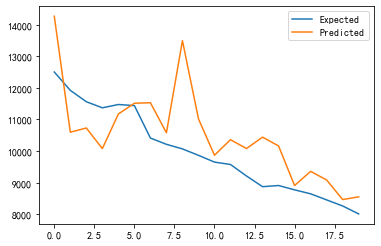

In [8]:
# 加载数据集
series = read_excel('../data/经济人口信息.xlsx')
values = series[['幼儿园数']].values
# 将时间序列数据转换为有监督学习  
data = series_to_supervised(values, n_in=12)
# 评估
mae, y, yhat = walk_forward_validation(data, 20)
print('MAE: %.3f' % mae)
# 绘制预测结果图
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [9]:
asarray([row])

array([[335.46      , 332.28      , 325.14      , 333.33      ,
        344.06      , 346.73      , 349.58      , 354.5       ,
        356.99      , 355.02      , 354.01      , 360.57      ,
        367.11      , 372.73      , 372.72866821, 372.72866821,
        372.72866821, 372.72866821, 372.72866821, 372.72772217]])